In [1]:
import pandas as pd
from urllib.parse import unquote
from time import time
starttime = time()

# Read data

In [2]:
df = pd.read_json('data-1.json',encoding='utf-8')

# Match similar category labels

In [3]:
CAT= {
    #category: change to this
    'ข่าวบันเทิง':"entertainment",
    'regional':'local',
    'sport':'sports',
    'ข่าวกีฬา':'sports',
    'ข่าวอาชญากรรม':'crime',
    'khrongkhaidaasapparod':'ข่าวโครงข่ายตาสับปะรด',
    'around-the-world-news':'foreign',
    'abroad':'foreign',
    'ข่าวต่างประเทศ':'foreign',
    'ข่าวไลฟ์สไตล์':'lifestyle',
    'analysis-today-politics':'politics',
    'politic':'politics',
    'ข่าวเศรษฐกิจ':'economics',
    'economy':'economics',
    'economic':'economics',
    'uncategorized':'others',
    'auto':'car-vehicle',
    'thai-soccer':'thaifootball',
    'ข่าวพระราชสำนัก':'royalnews',
    'it':'tech'
}

def conv_cate(category):
    result = CAT.get(category,-1)
    if result!=-1:
        return result
    else :
        #in case want to update dictionary
        #CAT[category] = category
        return category

# Undo URL encoding and match similar categories

In [4]:
df['category'] = df['category'].apply(unquote).apply(conv_cate)

# Choose Top 9 categories from data

In [5]:
import numpy as np
category = np.array(df['category'])
tags, freq = np.unique(category,return_counts=True)
freqList = list(zip(tags,freq))
freqList.sort(key=lambda elem:elem[1],reverse=True) #sort by frequency

#get category with lots of data examples
topCats = [category[0] for category in freqList[:9]]
topCats

['local',
 'foreign',
 'politics',
 'sports',
 'entertainment',
 'article',
 'economics',
 'crime',
 'eurofootball']

In [6]:
X = np.array(df[df.category.isin(topCats)]['news_content'])
y = np.array(df[df.category.isin(topCats)]['category'])

# Clean Text

In [7]:
import re

def text_prepare(text):
    text = re.sub('[^ก-๙‘’“”]', '', text)
    return text

In [8]:
X = np.array([text_prepare(body) for body in X])

# Split data into train and test sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Tokenize thai words

In [10]:
from pythainlp.tokenize import word_tokenize

In [11]:
#tokenize function
def Thaitokenize(text):
    """
    turn a Thai sentence into Thai words with meaning
    """
    #text = ''.join(text.split('"')) ##handled in regex??
    text = word_tokenize(text , engine = 'pyicu')
    return text

In [12]:
from pythainlp.corpus.common import thai_stopwords
thai_stopwords = thai_stopwords()

# Count Vectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vec1 = CountVectorizer(tokenizer=Thaitokenize, ngram_range=(1,3),stop_words=thai_stopwords)
X_train_bow = vec1.fit_transform(X_train)
X_test_bow = vec1.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# TFIDF Vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec2 = TfidfVectorizer(tokenizer=Thaitokenize, max_df=0.9, min_df = 5, ngram_range=(1,3),stop_words=thai_stopwords)
X_train_tfidf = vec2.fit_transform(X_train)
X_test_tfidf = vec2.transform(X_test)
#print(vectorizer.get_feature_names())
#print(X_train_tfidf.shape)

# Train Model

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#BOW
clf1 = OneVsRestClassifier(SVC(kernel='rbf')).fit(X_train_bow, y_train)
y_pred_bow = clf1.predict(X_test_bow)

#Tfidf
clf2 = OneVsRestClassifier(SVC(kernel='rbf')).fit(X_train_tfidf, y_train)
y_pred_tfidf = clf2.predict(X_test_tfidf)

# Accuracy

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm1 = confusion_matrix(y_test, y_pred_bow)
print(cm1)
print(accuracy_score(y_test, y_pred_bow))

cm2 = confusion_matrix(y_test, y_pred_tfidf)
print(cm2)
print(accuracy_score(y_test, y_pred_tfidf))

[[ 7  0  1  3  0  4  5  2  2]
 [ 0  5  0  0  0  1 14  0  0]
 [ 0  0 15  0  0  3  5  3  1]
 [ 1  0  1 16  0  0  7  1  2]
 [ 0  0  0  0  8  0  0  0 12]
 [ 0  0  0  0  0 79  3  0  1]
 [ 0  0  1  0  0  4 80  3  4]
 [ 1  0  0  2  0  7  9 45  1]
 [ 1  0  0  2  0  1  1  0 60]]
0.7429245283018868
[[ 2  0  0  1  0  5 10  5  1]
 [ 0  7  0  0  0  0 13  0  0]
 [ 0  0 15  0  0  3  4  4  1]
 [ 2  0  0 17  0  2  4  1  2]
 [ 0  0  0  0  9  0  0  0 11]
 [ 0  0  0  0  0 80  3  0  0]
 [ 0  2  3  1  0  3 72 10  1]
 [ 0  0  0  0  0  5  3 57  0]
 [ 1  0  0  0  0  1  0  0 63]]
0.7594339622641509


In [17]:
print('Execution time: ',(time()-starttime), 's')

Execution time:  98.67243456840515 s


# Predict category with a single sentence

In [18]:
test = text_prepare('“อนุทิน” ขอ ผู้ร้อง เปิดชื่อ อักษรย่อ \"พ\" คนหักหัวคิวโรงแรม 40%')

#BOW
test1 = vec1.transform([test])
print(clf1.predict(test1))

#TFIDF
test2 = vec2.transform([test])
print(clf2.predict(test2))

['article']
['politics']


# Observe relationship of amount of data supplied and correctly predicted

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

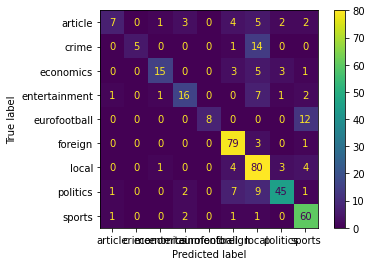

In [20]:
plot_confusion_matrix(clf1, X_test_bow, y_test)

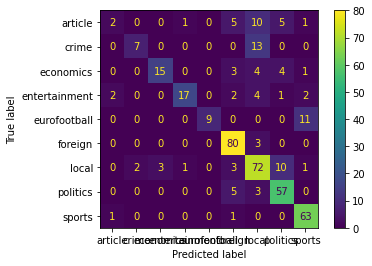

In [21]:
plot_confusion_matrix(clf2, X_test_tfidf, y_test)

In [22]:
tags, freq = np.unique(y_train,return_counts=True)
list(zip(tags,freq))

[('article', 74),
 ('crime', 60),
 ('economics', 69),
 ('entertainment', 101),
 ('eurofootball', 58),
 ('foreign', 255),
 ('local', 265),
 ('politics', 196),
 ('sports', 192)]